In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
from anndata import AnnData
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import anndata as ad

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=160, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


# QC Filtering

In [3]:
adata = sc.read_h5ad('path/to/adatas/P7_adata_raw.h5ad')

In [4]:
print(len(adata.obs))

81603


In [5]:
sc.pp.filter_cells(adata, min_genes=700)

filtered out 442 cells that have less than 700 genes expressed


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


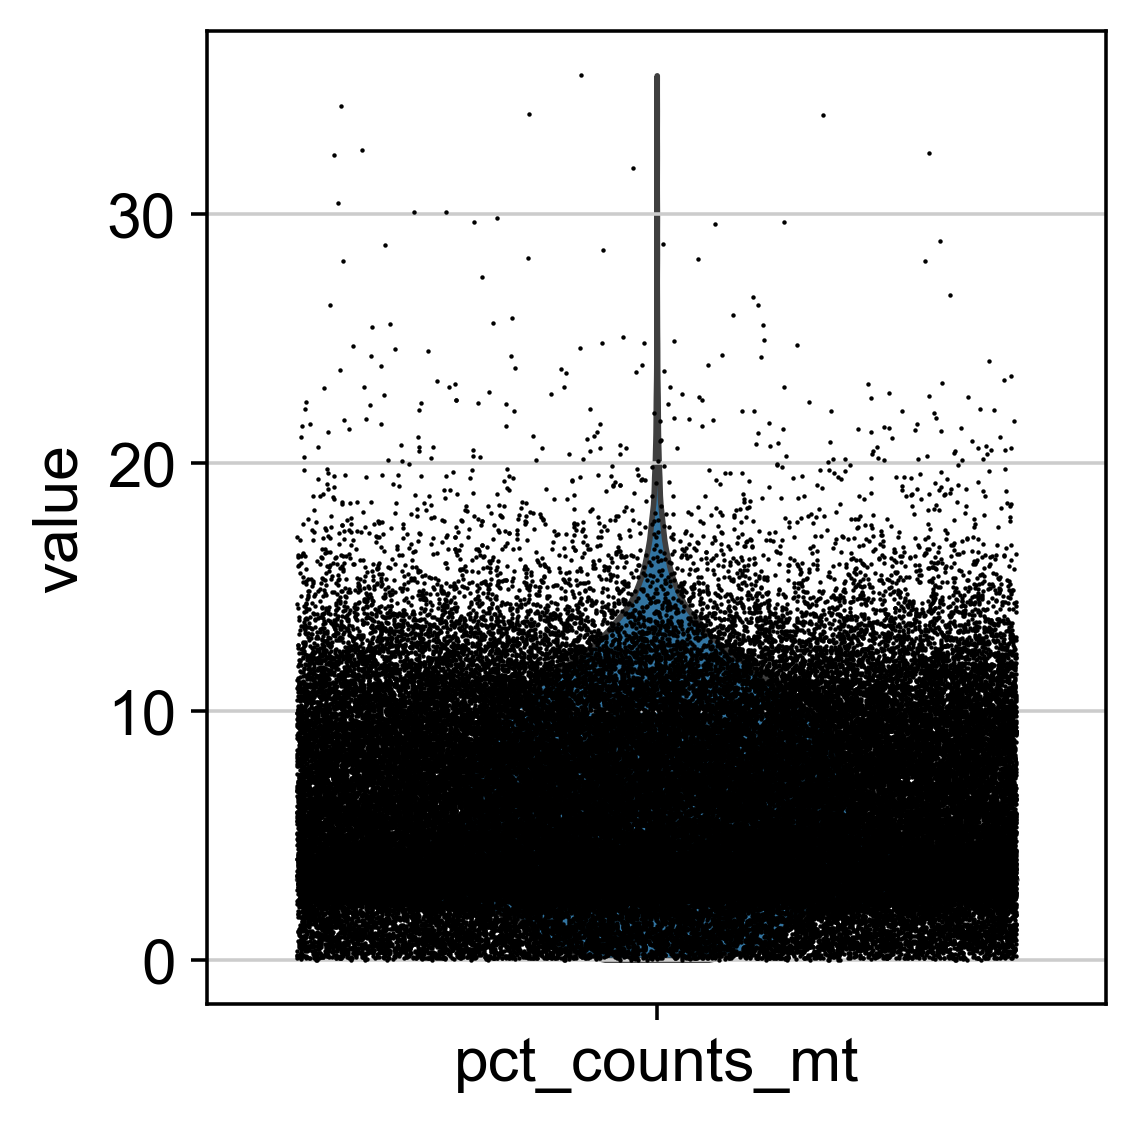

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


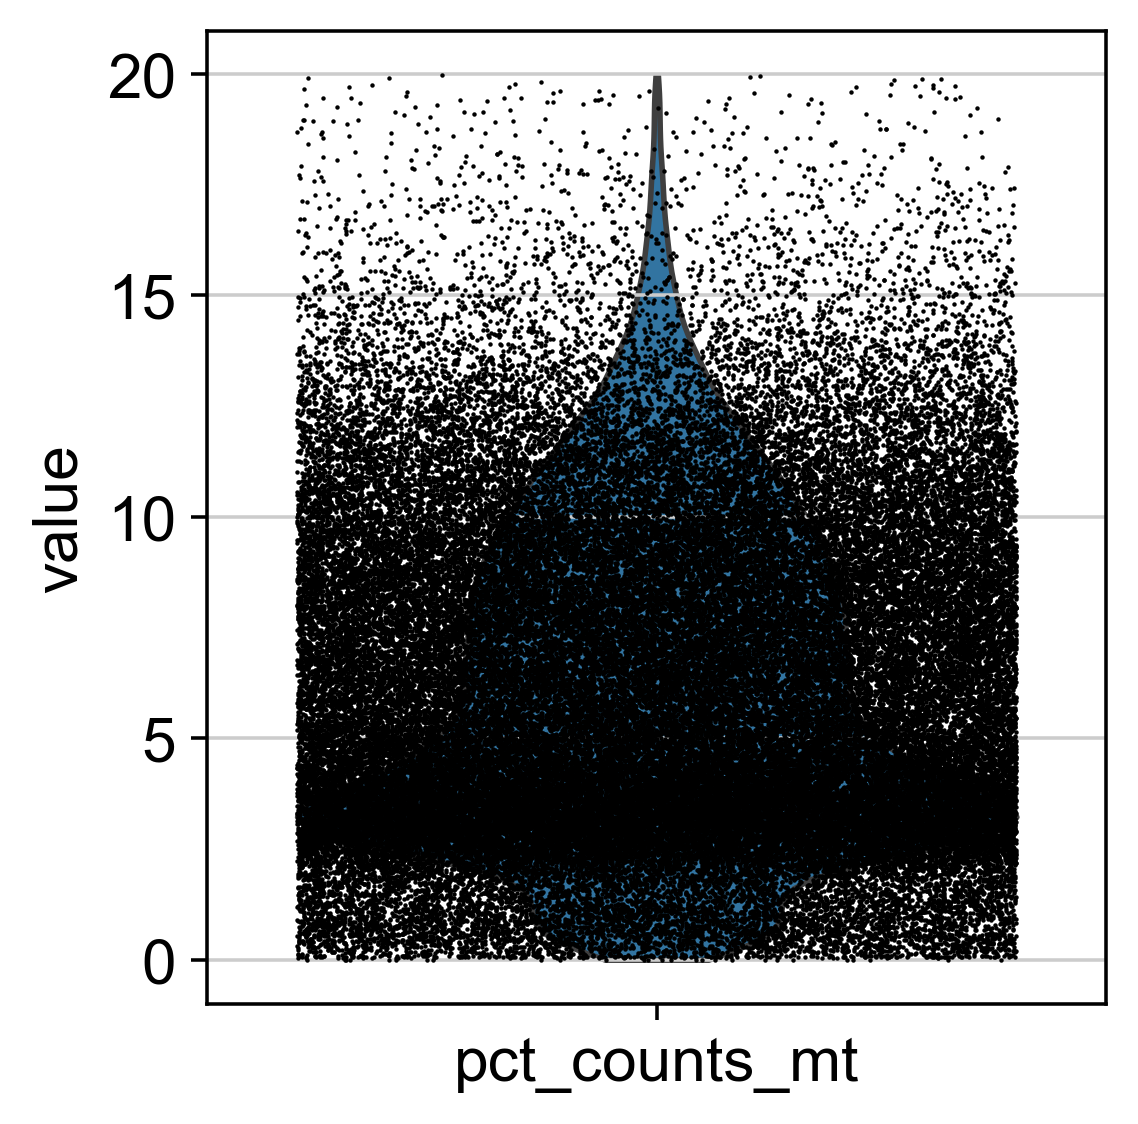

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)
sc.pl.violin(adata[adata.obs.pct_counts_mt < 20, :], ['pct_counts_mt'], jitter=0.4)

In [7]:
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [8]:
print(len(adata.obs))

67536


Text(0, 0.5, 'UMI Counts')

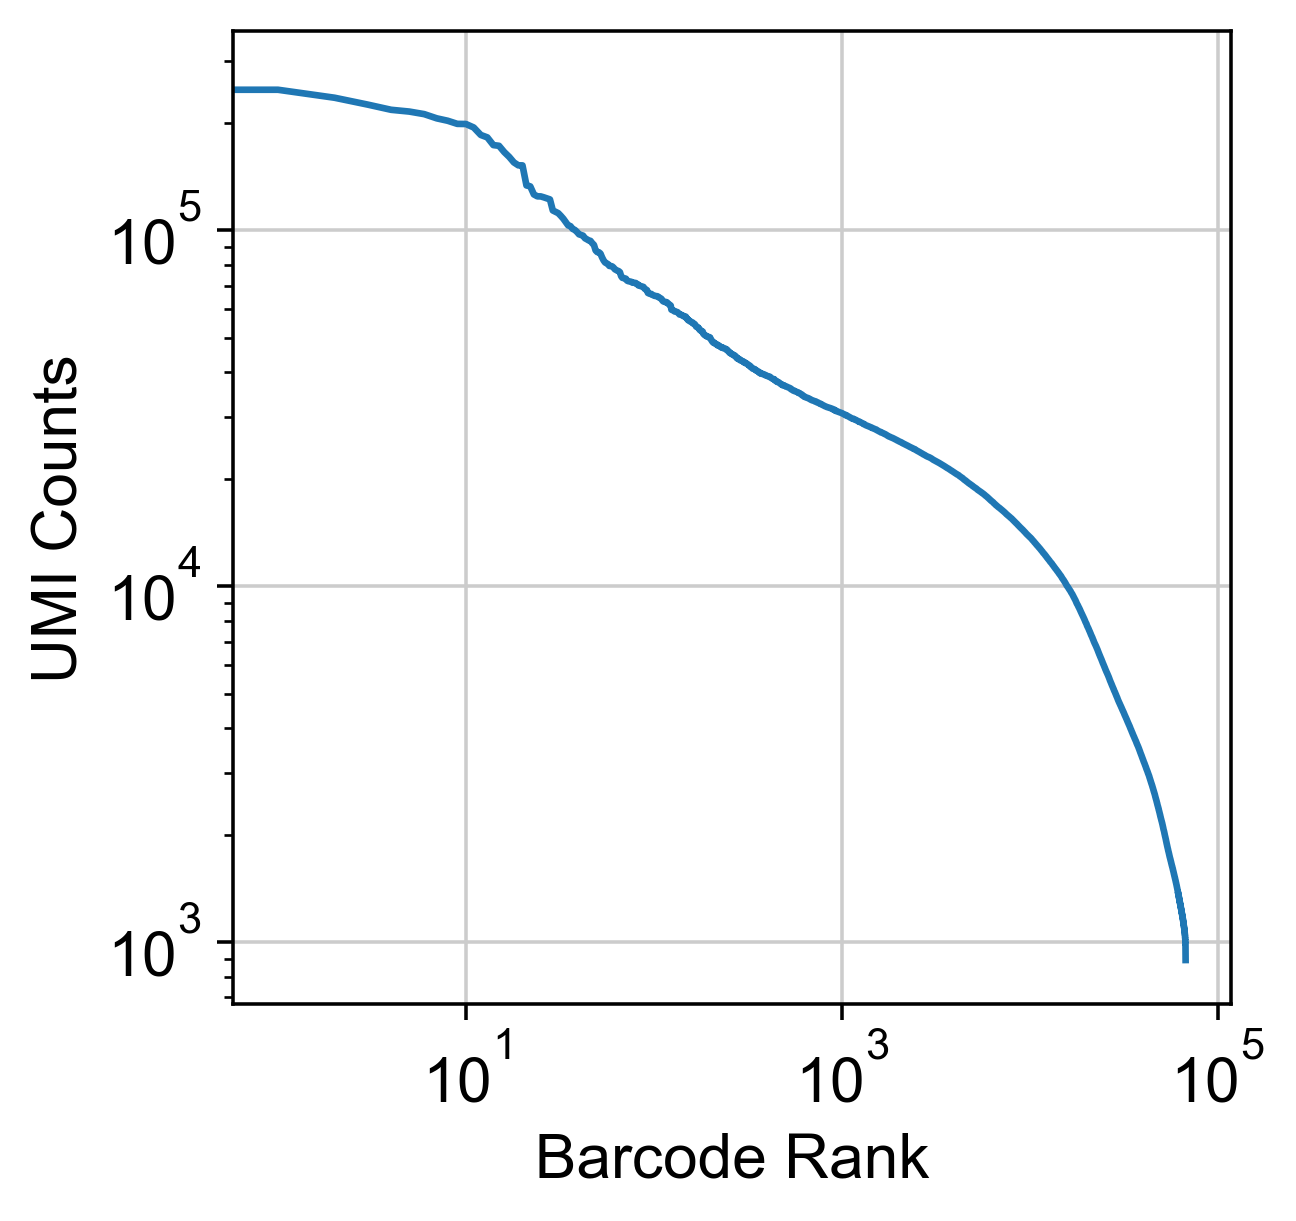

In [9]:
total_counts_list = list(sorted(list(adata.obs['total_counts']), reverse=True))
plt.plot(np.arange(len(total_counts_list)), total_counts_list)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Barcode Rank')
plt.ylabel('UMI Counts')

In [10]:
adata = adata[adata.obs.total_counts > 5000, :]

In [11]:
print(len(adata.obs))

28592


# Processing and Visualization

In [12]:
adata.obs['total_counts_raw'] = adata.obs['total_counts']

C:\Users\pomat\AppData\Local\Temp\ipykernel_10904\2049803437.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['total_counts_raw'] = adata.obs['total_counts']


In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
adata.obs

Batch  n_genes  n_genes_by_counts  total_counts  \
AAACCCAAGAAAGTCT-1_1  Batch1     4249               4249       16046.0   
AAACCCACACATATCG-1_1  Batch1     4897               4897       14829.0   
AAACCCACAGTCGAGA-1_1  Batch1     4948               4948       18603.0   
AAACCCACATAGACTC-1_1  Batch1     3855               3855       10523.0   
AAACCCACATCATCTT-1_1  Batch1     4499               4499       12396.0   
...                      ...      ...                ...           ...   
TTTGTTGGTATGAGAT-1_3  Batch3     2695               2695        5986.0   
TTTGTTGGTCATAACC-1_3  Batch3     3305               3305        9177.0   
TTTGTTGTCATGCCAA-1_3  Batch3     2660               2660        6261.0   
TTTGTTGTCGCATGAT-1_3  Batch3     4080               4080       12650.0   
TTTGTTGTCTTCCAGC-1_3  Batch3     4213               4213       12762.0   

                      total_counts_mt  pct_counts_mt  total_counts_raw  
AAACCCAAGAAAGTCT-1_1            464.0       2.891686           16046.0  
AAACCCACACATATCG-1_1            631.0       4.255176           14829.0  
AAACCCACAGTCGAGA-1_1            698.0       3.752083           18603.0  
AAACCCACATAGACTC-1_1            861.0       8.182077           10523.0  
AAACCCACATCATCTT-1_1            412.0       3.323653           12396.0  
...                               ...            ...               ...  
TTTGTTGGTATGAGAT-1_3            195.0       3.257601            5986.0  
TTTGTTGGTCATAACC-1_3            373.0       4.064509            9177.0  
TTTGTTGTCATGCCAA-1_3            207.0       3.306181            6261.0  
TTTGTTGTCGCATGAT-1_3            399.0       3.154150           12650.0  
TTTGTTGTCTTCCAGC-1_3            294.0       2.303714           12762.0  

[28592 rows x 7 columns]

In [17]:
adata.raw = adata

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [20]:
sc.pp.regress_out(adata, 'total_counts')

regressing out total_counts
    sparse input is densified and may lead to high memory use
    finished (0:00:20)


In [21]:
sc.pp.scale(adata, max_value=10)

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [23]:
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'Batch')
adata.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [24]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_harmony', knn=True)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:06)


In [25]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


In [26]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 43 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [27]:
cluster_nums = []
for i in range(adata.shape[0]):
    cluster_num = int(adata.obs.leiden[i])+1
    cluster_num = str(cluster_num)
    cluster_nums.append(cluster_num)

adata.obs['Cluster'] = pd.Categorical(cluster_nums)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


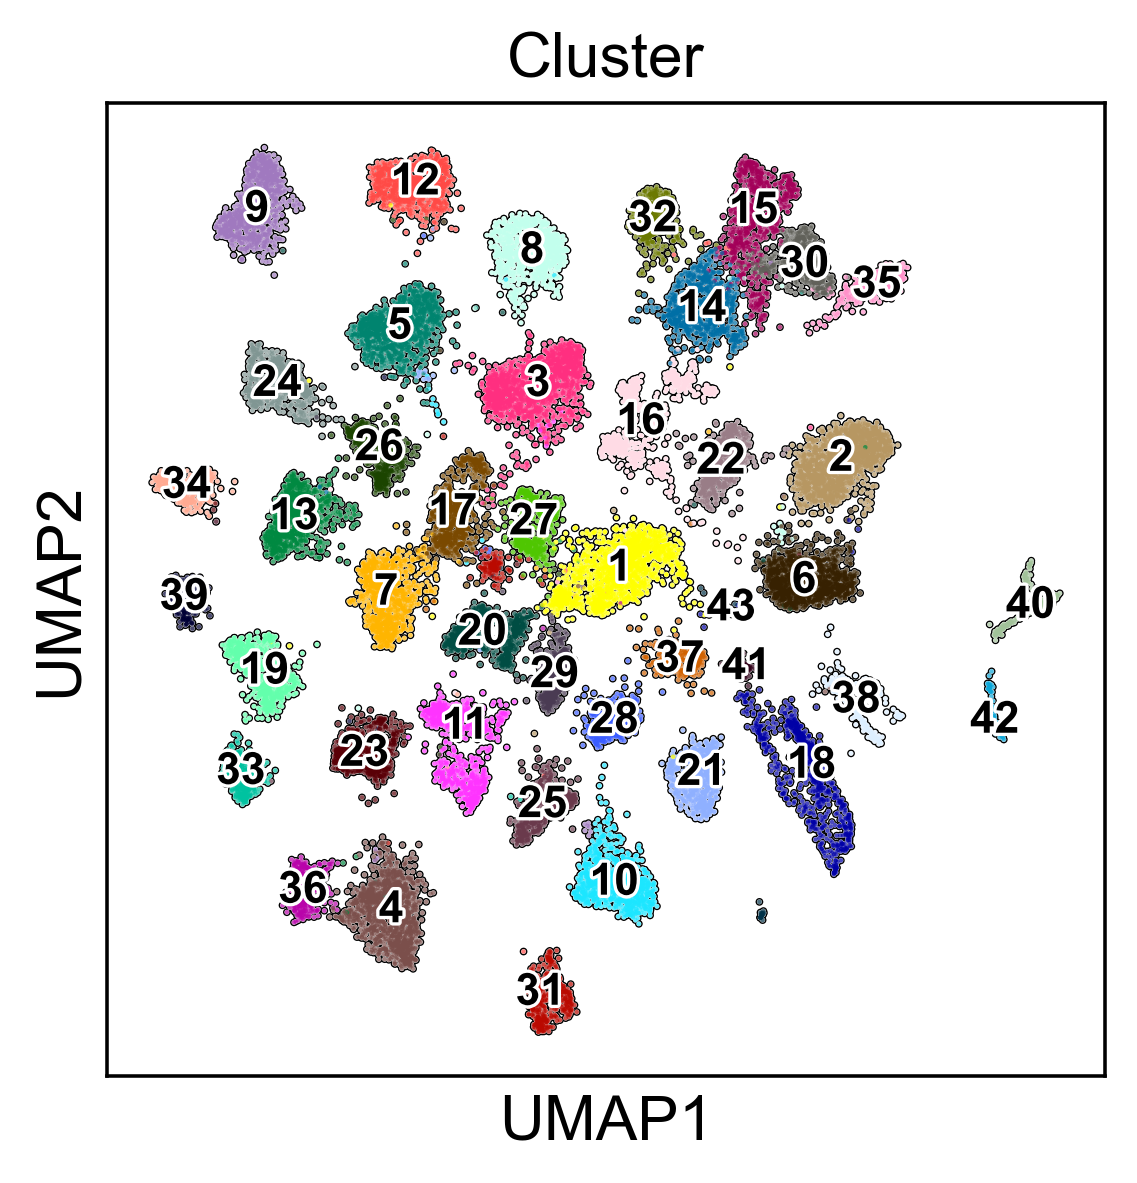

In [28]:
sc.set_figure_params(dpi=160)
sc.pl.umap(adata, color=['Cluster'], add_outline=True, legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


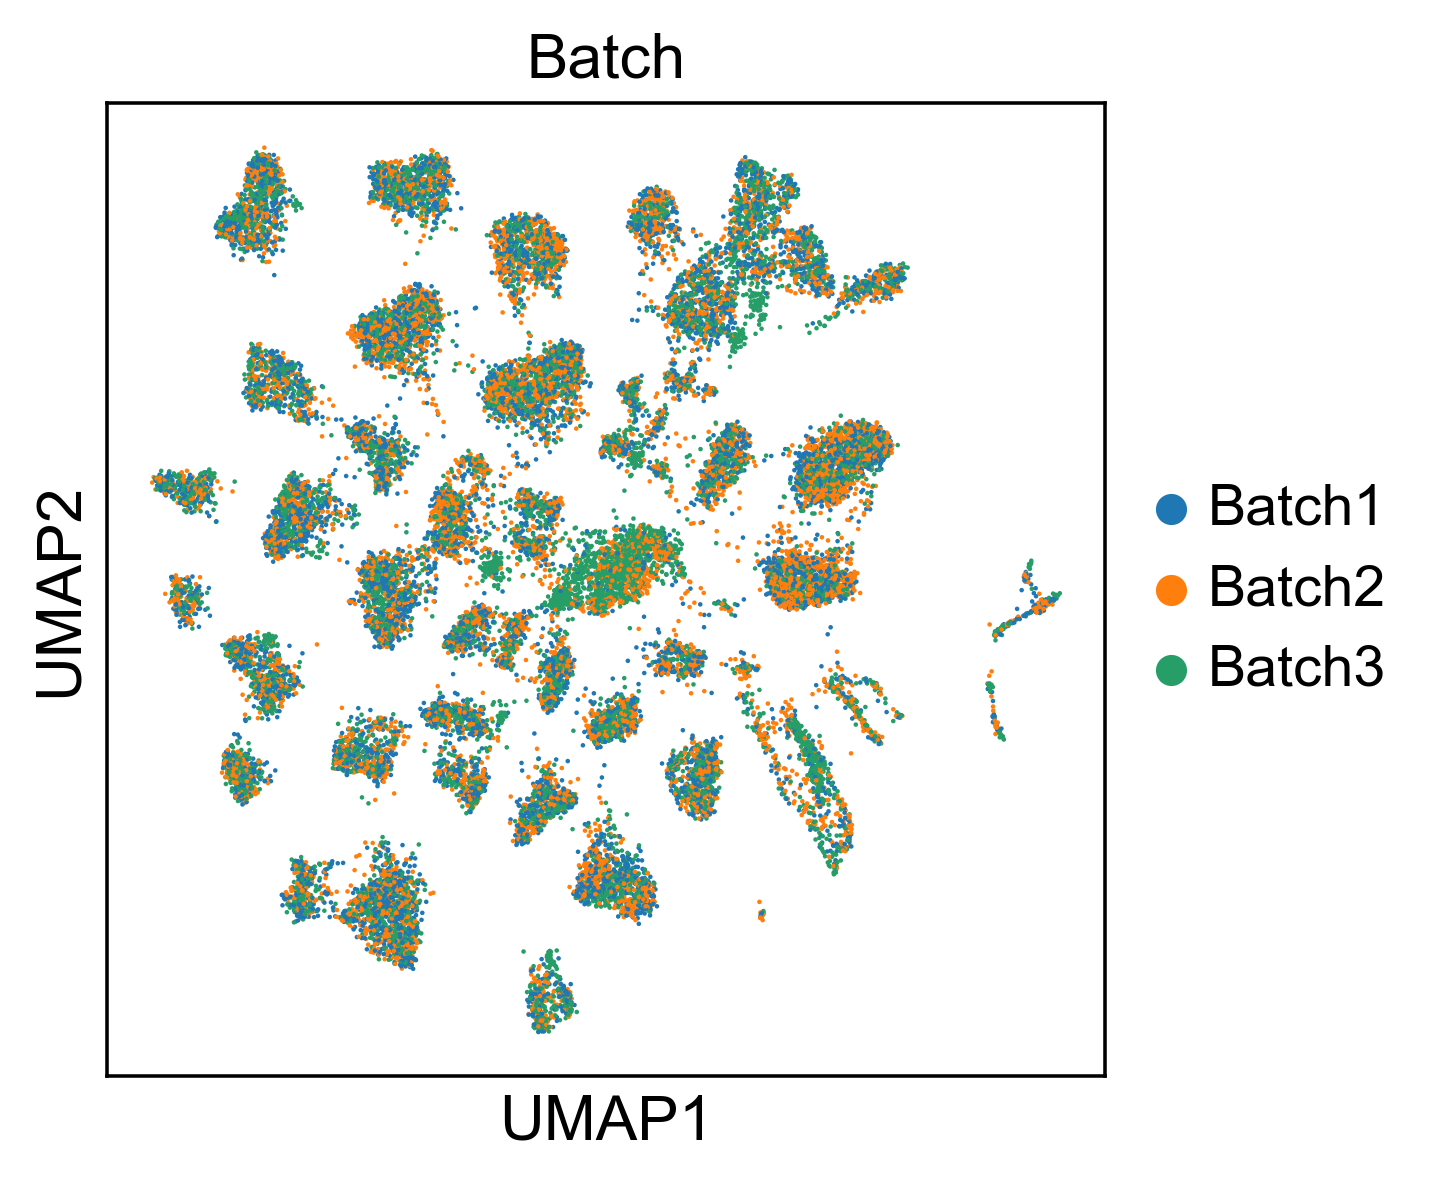

In [29]:
sc.pl.umap(shuffle(adata), color=['Batch'])

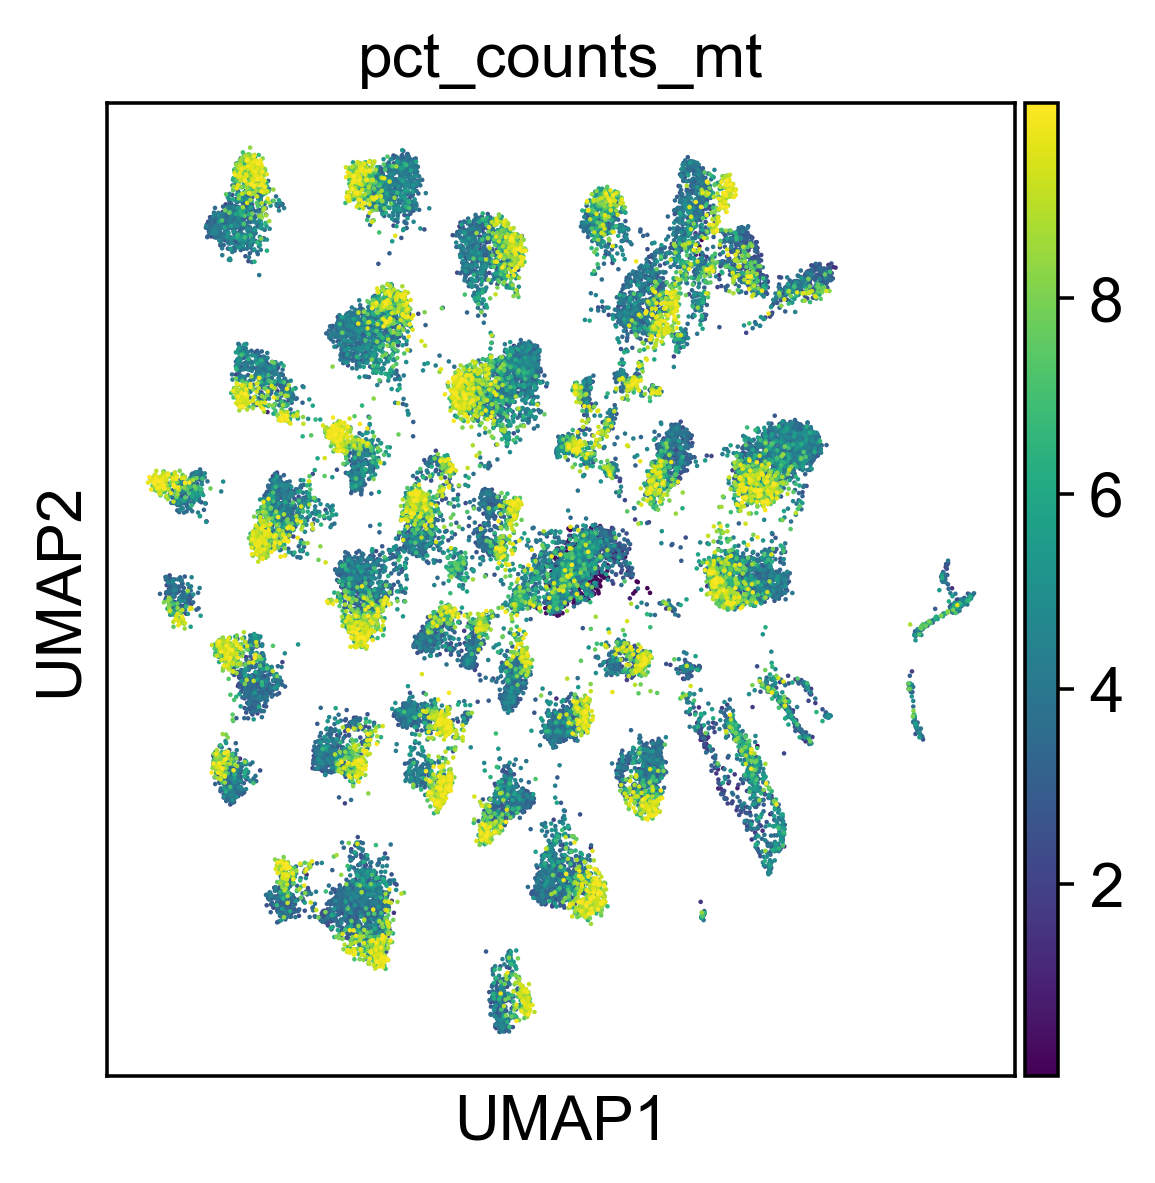

In [30]:
sc.pl.umap(adata, color=['pct_counts_mt'])

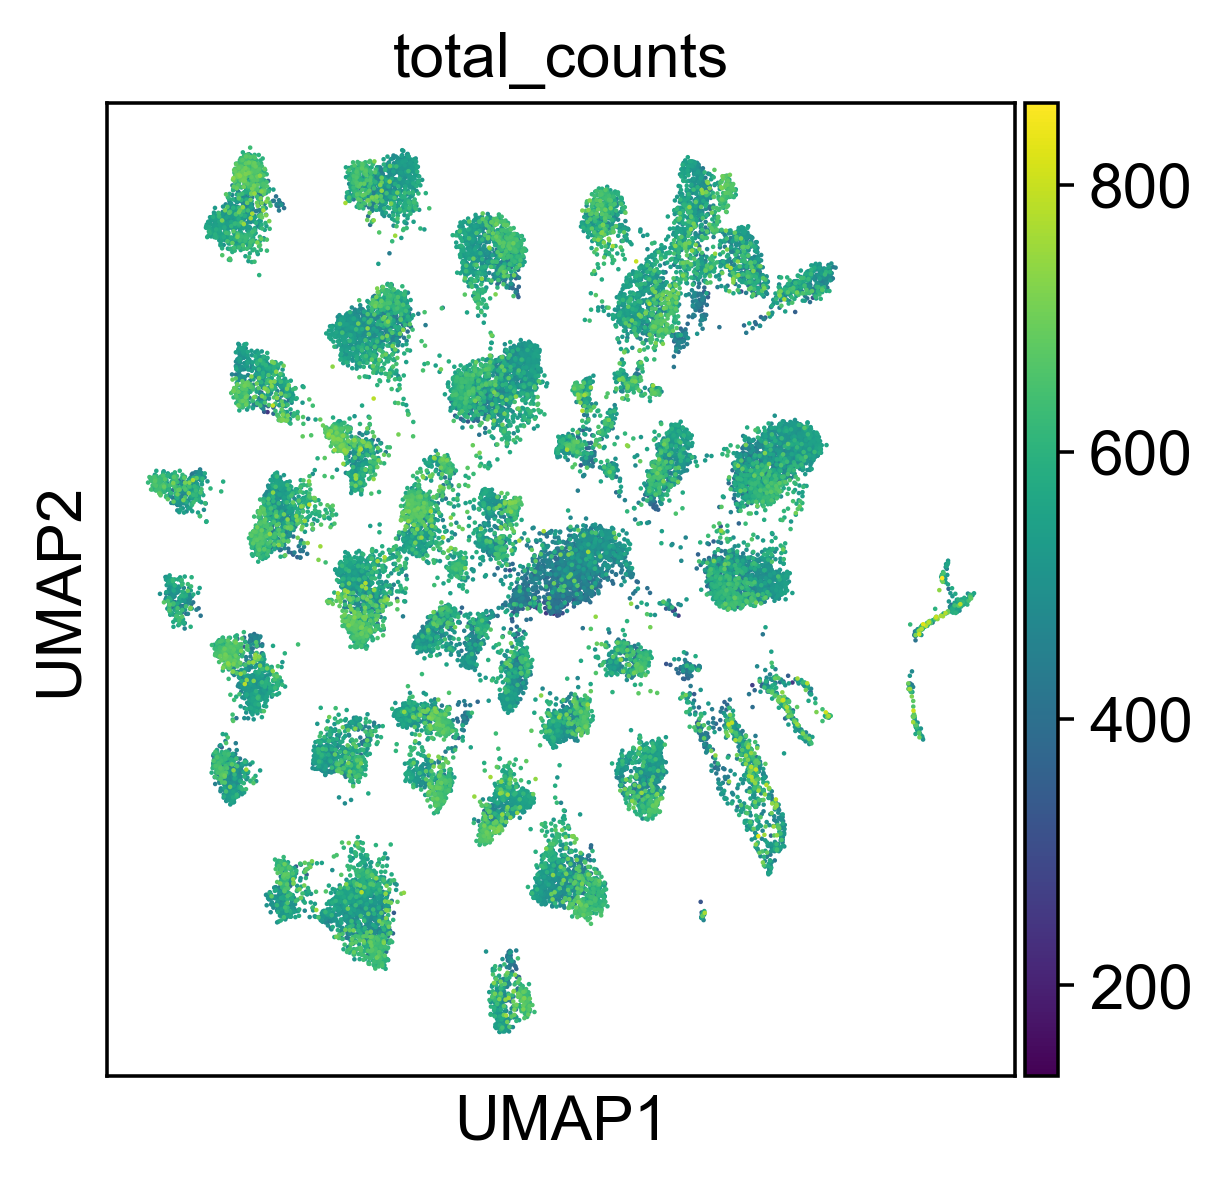

In [31]:
sc.pl.umap(adata, color=['total_counts'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


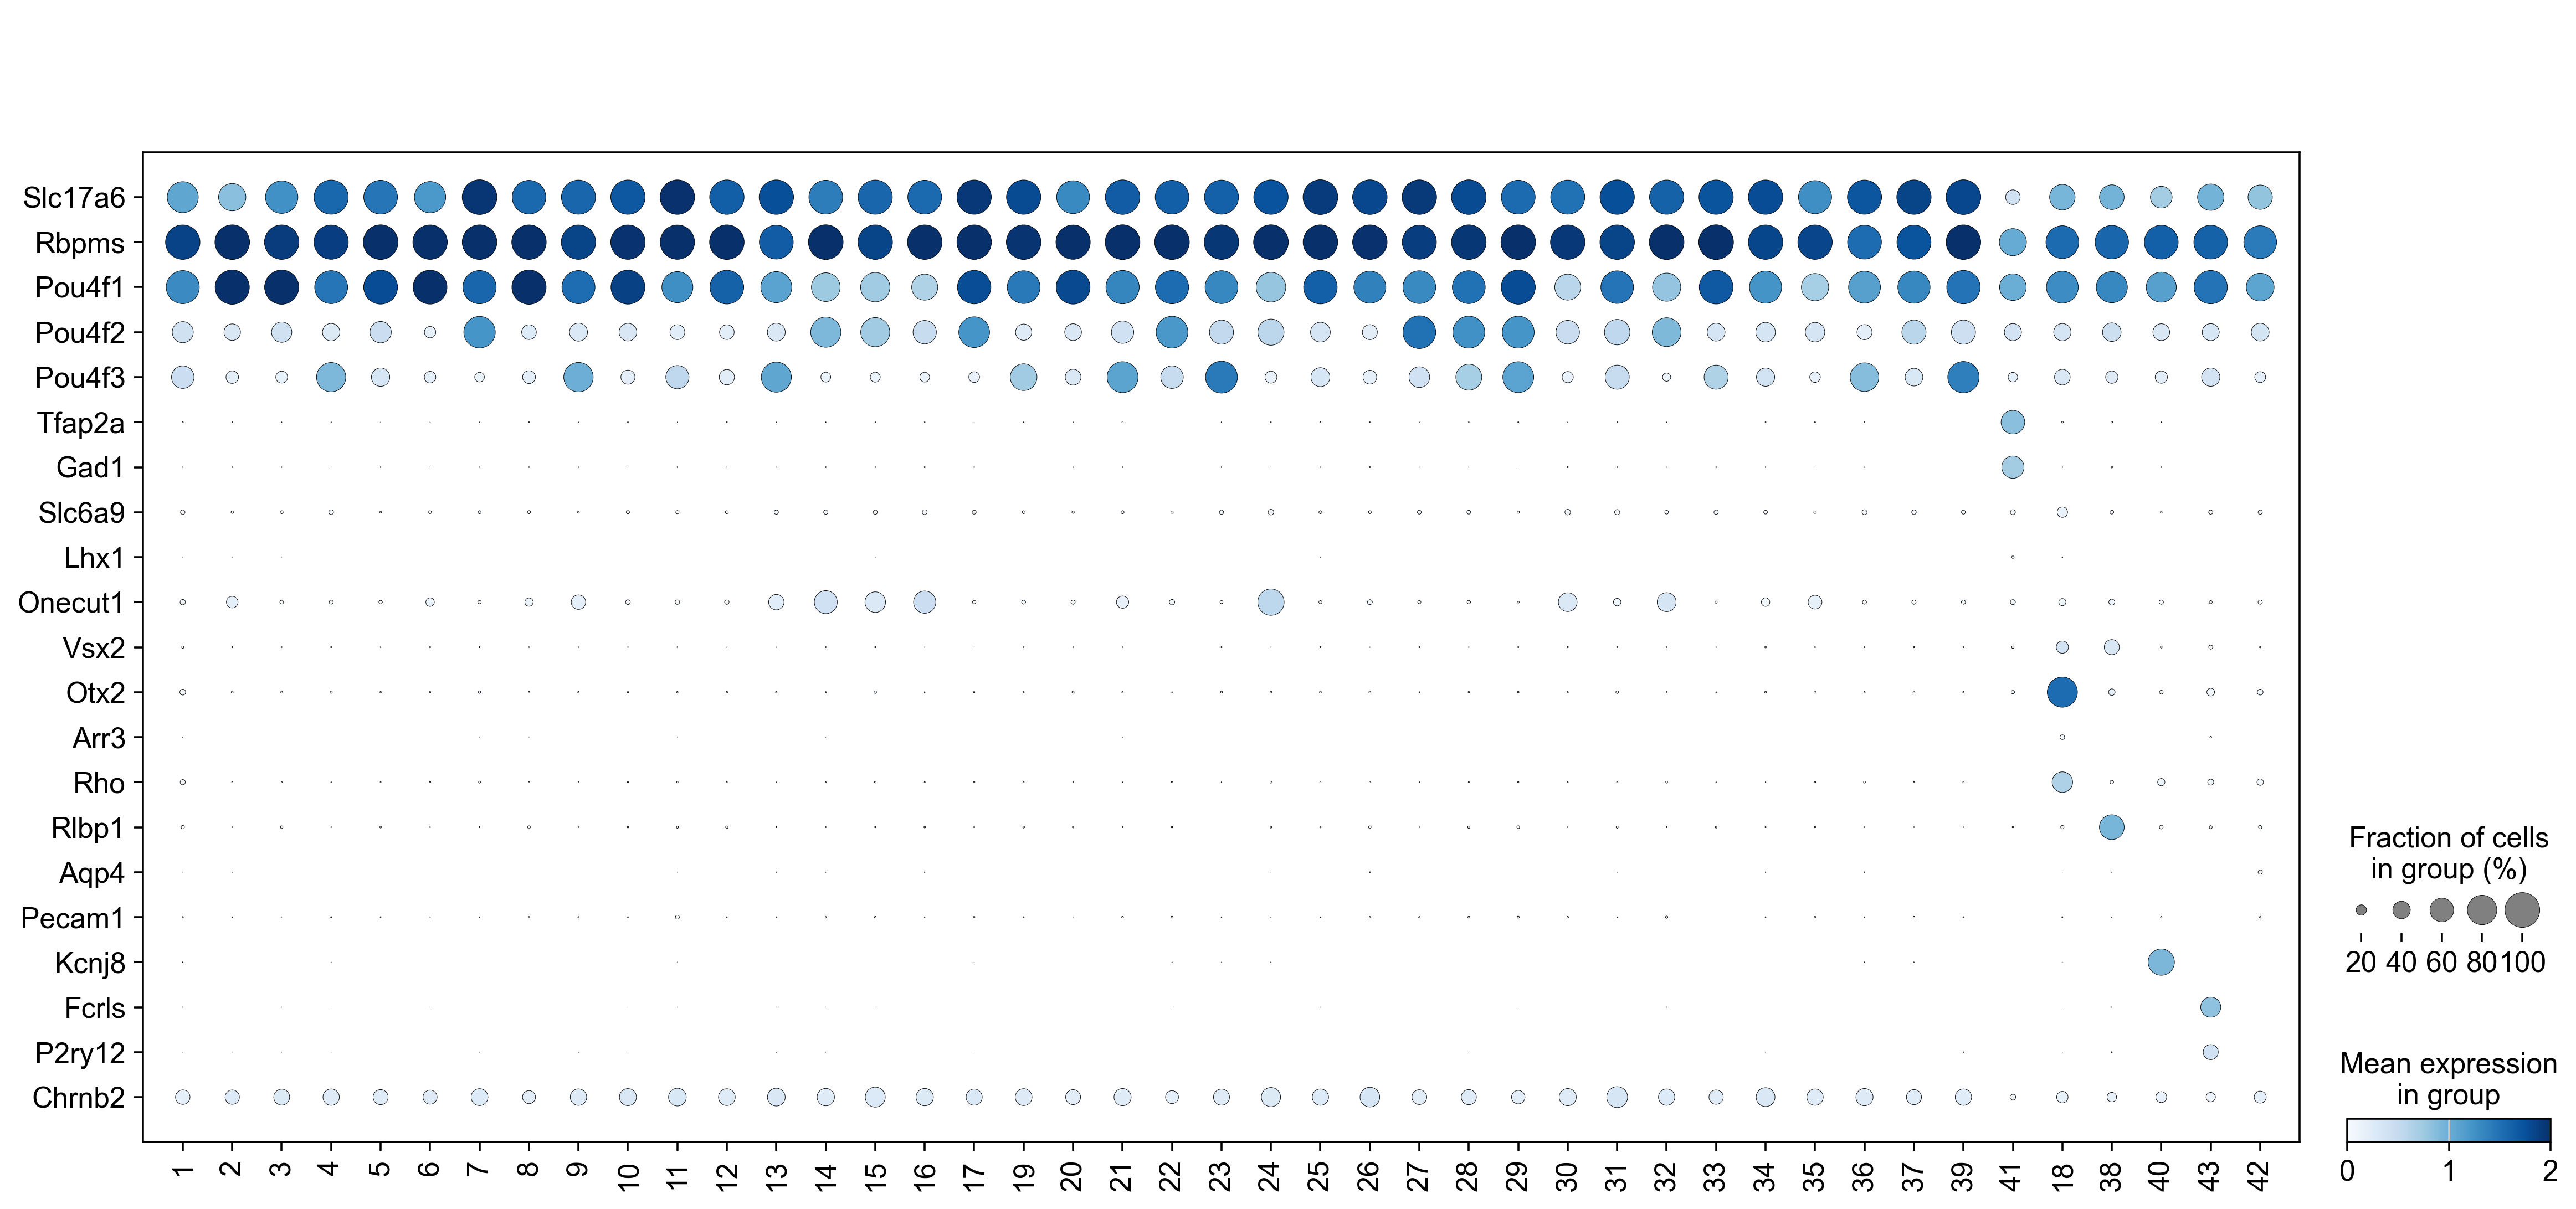

In [38]:
class_markers = ['Slc17a6', 'Rbpms', 'Pou4f1', 'Pou4f2', 'Pou4f3', 'Tfap2a', 'Gad1', 'Slc6a9', 'Lhx1', 'Onecut1', 'Vsx2', 'Otx2', 'Arr3', 'Rho', 'Rlbp1', 'Aqp4', 'Pecam1', 'Kcnj8', 'Fcrls', 'P2ry12', 'Chrnb2']
cluster_order = []
for i in range(len(adata.obs['Cluster'].cat.categories)):
    cluster_order.append(str(i+1))
ending_order = ['41', '18', '38', '40', '43', '42']
for i in ending_order:
    cluster_order.remove(i)
    cluster_order.append(i)
sc.pl.dotplot(adata, var_names=class_markers, groupby='Cluster', swap_axes=True, categories_order=cluster_order, vmax=2, save='P7_classes.svg', cmap='Blues')

In [36]:
adata.write('path/to/adatas/P7_adata.h5ad')